In [38]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from sklearn.preprocessing import PolynomialFeatures
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q,test_traj
from optimize import Run_eval_test,optimize_parallel_new 
from utils import *
import copy

In [39]:
def H(k, x):
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    c = np.zeros(k+1,dtype = float)
    c[k] = 1.0
    h = P.hermite_e.hermeval(x,c) / np.sqrt(sp.special.factorial(k)) 
    return h

def compute_H(k,x):
    return H(k[0],x[:,0])*H(k[1],x[:,1])

In [40]:
def approx_q(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    #print("dimension = ",dim)
    coefs_poly = np.array([])
    for i in range(lag):
        x_all = np.array([])
        y_all = np.array([])
        for j in range(N_traj_train):
            y = Y_train[j,i:,0]
            if i == 0:
                x = X_train[j,:]
            else:
                x = X_train[j,:-i]
            #concatenate results
            if x_all.size == 0:
                x_all = x
            else:
                x_all = np.concatenate((x_all,x),axis = 0)
            y_all = np.concatenate([y_all,y])
        #should use polyfeatures here
        #print("variance: ",np.var(y_all))
        #print(y_all[:50])
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        #print(X_features.shape)
        lstsq_results = np.linalg.lstsq(X_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,X_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

In [41]:
def test_traj(coefs_poly_regr,gamma,r_seed,lag,d,N_test,x0):
    """
    function to perform 2-dimensional martingale decomposition
    """
    X_test,Noise = generate_traj(x0,N_test,gamma,r_seed,d)
    test_stat_vanilla = np.zeros(N_test,dtype = float)
    test_stat_vr = np.zeros_like(test_stat_vanilla)
    #compute number of basis polynomials
    basis_funcs = np.array([[1,0],[0,1],[1,1],[2,0],[0,2]])
    num_basis_funcs = len(basis_funcs)
    #compute polynomials of noise variables Z_l
    poly_vals = np.zeros((num_basis_funcs,N_test), dtype = float)
    for k in range(len(basis_funcs)):
        poly_vals[k,:] = compute_H(basis_funcs[k],Noise)
    #initialize function
    f_vals_vanilla = np.sum(X_test,axis=1)
    #array to store control variates values
    cvfs = np.zeros_like(f_vals_vanilla)
    #compute coeffitients bar_a
    bar_a_0_1 = np.zeros((lag,N_test),dtype=float)
    bar_a_1_0 = np.zeros_like(bar_a_0_1)
    bar_a_1_1 = np.zeros_like(bar_a_0_1)
    bar_a_2_0 = np.zeros_like(bar_a_0_1)
    bar_a_0_2 = np.zeros_like(bar_a_0_1)
    for i in range(lag):
        #coefficients with H_0_1
        bar_a_0_1[i,1:] = coefs_poly_regr[i,2]*np.sqrt(2*gamma)+\
                        2*coefs_poly_regr[i,5]*np.sqrt(2*gamma)*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]+\
                        coefs_poly_regr[i,4]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0]*np.sqrt(2*gamma)
        bar_a_0_1[i,0] = coefs_poly_regr[i,2]*np.sqrt(2*gamma)+\
                        2*coefs_poly_regr[i,5]*np.sqrt(2*gamma)*(x0 + gamma*b(x0))[1]+\
                        coefs_poly_regr[i,4]*(x0 + gamma*b(x0))[0]*np.sqrt(2*gamma)
        #coefficients with H_1_0
        bar_a_1_0[i,1:] = coefs_poly_regr[i,1]*np.sqrt(2*gamma)+\
                        coefs_poly_regr[i,4]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]*np.sqrt(2*gamma)+\
                        2*coefs_poly_regr[i,3]*np.sqrt(2*gamma)*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0]
        bar_a_1_0[i,0] = coefs_poly_regr[i,1]*np.sqrt(2*gamma)+\
                        coefs_poly_regr[i,4]*(x0 + gamma*b(x0))[1]*np.sqrt(2*gamma)+\
                        2*coefs_poly_regr[i,3]*np.sqrt(2*gamma)*(x0 + gamma*b(x0))[1]
        #second-order coefficients
        #coefficients with H_1_1
        #bar_a_1_1[i,:] = 2*coefs_poly_regr[i,4]*gamma
        #coefficients with H_2_0
        bar_a_2_0[i,1:] = 2*np.sqrt(2)*coefs_poly_regr[i,3]*gamma
        #coefficients with H_0_2
        bar_a_0_2[i,1:] = 2*np.sqrt(2)*coefs_poly_regr[i,5]*gamma
    bar_a_1_0 = bar_a_1_0*poly_vals[0,:]
    bar_a_0_1 = bar_a_0_1*poly_vals[1,:]
    bar_a_1_1 = bar_a_1_1*poly_vals[2,:]
    bar_a_2_0 = bar_a_2_0*poly_vals[3,:]
    bar_a_0_2 = bar_a_0_2*poly_vals[4,:]
    #compute martingale sums
    M_n_0_1 = 0.0
    M_n_1_0 = 0.0
    M_n_1_1 = 0.0
    M_n_2_0 = 0.0
    M_n_0_2 = 0.0
    for l in range(N_test):
        for r in range(min(N_test-l,lag)):
            M_n_0_1 += bar_a_0_1[r,l]
            M_n_1_0 += bar_a_1_0[r,l]
            M_n_1_1 += bar_a_1_1[r,l]
            M_n_2_0 += bar_a_2_0[r,l]
            M_n_0_2 += bar_a_0_2[r,l]
    #print("M_n_0_1: ",M_n_0_1)
    #print("M_n_1_0: ",M_n_1_0)
    return np.mean(f_vals_vanilla), np.mean(f_vals_vanilla)-(M_n_0_1 + M_n_1_0)/N_test, np.mean(f_vals_vanilla)-(M_n_0_1 + M_n_1_0 + M_n_1_1 + M_n_2_0 + M_n_0_2)/N_test
#
#
#

In [42]:
a = np.random.randn(2)
b = np.random.randn(1000,2)
a = a.reshape((1,2))
c = a - b
print(c.shape)

(1000, 2)


In [43]:
#def b(X_t):
    #"""
    #b function in the diffusion
    #"""
    #normal case
    #return -X_t
p = 0.5
mu = np.array([0.5,0.5])
d=2
Sigma = np.eye(d)
#Sigma = GenerateSigma(d,rand_seed = 777,eps = 0.1) #covariation matrix 
Sigma_inv = np.linalg.inv(Sigma)

def b(x):
    #mixture case
    if len(x.shape) == 1:
        return mu - x - 2*(1-p)*mu/(1-p + p*np.exp(2*np.dot(mu,x)))
    else:
        denom = 1-p + p*np.exp(2*x@mu)
        return mu.reshape((1,2)) - x - (2*(1-p)*mu.reshape((-1,1))/denom).T

"""
def b(x):
    #mixture case
    if len(x.shape) == 1:
        return Sigma_inv @ (mu - x) - 2*(1-p)*Sigma_inv @ mu/(1-p + p*np.exp(2*np.dot(mu,Sigma_inv @ x)))
    else:
        #print(x.shape)
        denom = 1-p + p*np.exp(2*x @ (Sigma_inv @ mu))
        #print(denom.shape)
        return (mu.reshape((1,2)) - x)@Sigma_inv - (2*(1-p)*(Sigma_inv @ mu).reshape((-1,1))/denom).T
"""

def sample_discretized_diffusion(X_t,gamma_t,d):
    """
    args:   X_t - current value, 
            gamma_t - step size;
            d - dimension;
            cov - covariance matrix
    returns:  (X_{t+1},xi_{t+1}) - value at the next time moment and the corresponding noise variable
    """
    xi = np.random.randn(d)
    return X_t + gamma_t*b(X_t) + np.sqrt(2*gamma_t)*xi,xi

#currently we use this function without the burn-in
def generate_traj(x0,n,gamma,r_seed,d):
    """
    args:
        x0 - starting point;
        n - number of steps;
        gamma - step size (assumed to be fixed for now);
    returns:
        x_all,noise_all - np.arrays of shape (n,)  
    """
    x_all = np.zeros((n,d),dtype = float)
    noise_all = np.zeros((n,d),dtype = float)
    np.random.seed(r_seed)
    x_all[0],noise_all[0] = sample_discretized_diffusion(x0,gamma,d)
    for i in range(1,n):
        x_all[i],noise_all[i] = sample_discretized_diffusion(x_all[i-1],gamma,d)
    return x_all,noise_all

In [44]:
#lags = np.array([10,20,30,40,50,60,70,80,90,100])
lags = np.array([2,4,6,8,10,12,14,16,18,20])#,22,24,26,28,30])
vr_rates = []

In [45]:
n = 5*10**4 #sample size
gamma = 2e-1 #Step size
n_traj = 1
d = 2
n_traj_test = 96 # Number of independent MCMC trajectories for test
f_type = "linear"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 100 #maximal lag order
N_test = 1*10**4

In [46]:
x0 = np.array([0.0,0.0],dtype = float)
r_seed = 1812
X_train, noise_train = generate_traj(x0,n,gamma,r_seed,d)
#set target function
if f_type == "quadratic":
    Y_train = np.sum(X_train**2,axis=1)
elif f_type == "linear":
    Y_train = np.sum(X_train,axis=1)
X_train = X_train.reshape((1,-1,d))
Y_train = Y_train.reshape((1,-1,1))

### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [47]:
#polynomial coefficients
coefs_poly = approx_q(X_train,Y_train,n_traj,lag,S_max)
#print(coefs_poly.shape)
print(coefs_poly)
regr_vals = np.zeros((lag,X_train.shape[1]),dtype=float)
features = np.zeros((X_train.shape[1],6),dtype=float)
features[:,0] = 1.0
features[:,1:3] = X_train[0,:,:]
features[:,3] = X_train[0,:,0]**2 
features[:,4] = X_train[0,:,0]*X_train[0,:,1]
features[:,5] = X_train[0,:,1]**2
for i in range(len(regr_vals)):
    regr_vals[i,:] = np.sum(coefs_poly[i,:]*features,axis=1)

[[-6.56999910e-16  1.00000000e+00  1.00000000e+00 -1.67581555e-16
   8.28250697e-17 -3.10290153e-16]
 [ 2.63799226e-03  8.64928380e-01  8.70815772e-01  7.55818175e-04
   2.57274801e-05 -1.26862828e-03]
 [ 2.16551233e-03  7.49727229e-01  7.61341327e-01 -1.46005744e-04
  -4.93885031e-03  2.05369089e-03]
 [ 4.65093146e-03  6.48272140e-01  6.67194625e-01 -8.87588772e-04
  -4.64486202e-03  1.95095459e-03]
 [-5.54481700e-04  5.62866246e-01  5.78166442e-01  2.05782076e-03
  -7.76082534e-03  4.37087764e-03]
 [-1.78481997e-03  4.85574815e-01  5.00530711e-01  5.01913663e-03
  -6.20445847e-03  2.89921589e-03]
 [-1.27940207e-04  4.20865677e-01  4.32283393e-01  6.28536236e-03
  -1.94690410e-03  3.75783022e-04]
 [ 5.98537352e-03  3.67134432e-01  3.74012024e-01  4.94352822e-03
   1.14960265e-03 -2.70760609e-03]
 [ 7.85086273e-03  3.20047531e-01  3.24426311e-01  4.29509201e-03
   5.79242791e-03 -3.77343071e-03]
 [ 8.31822449e-03  2.80453139e-01  2.79658075e-01  4.35662526e-03
   4.88538479e-03 -3.5041

Test regression

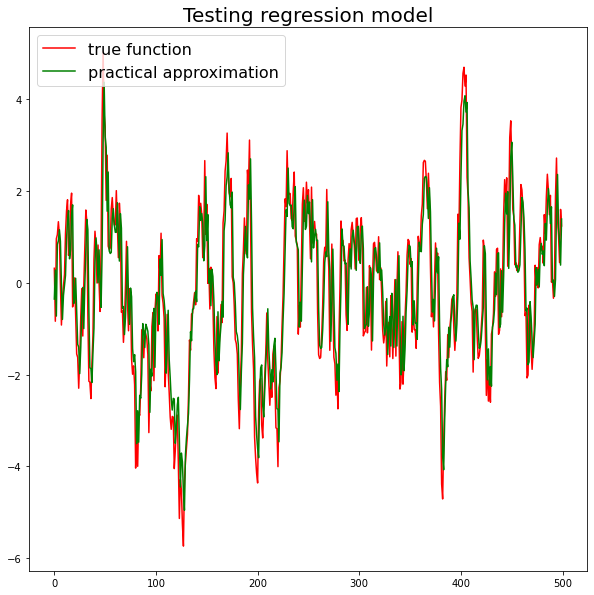

In [48]:
cur_lag = 1
N_pts = 500
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(Y_train[0,cur_lag:N_pts+cur_lag,0],color='r',label='true function')
plt.plot(regr_vals[cur_lag,:N_pts],color='g',label = 'practical approximation')
plt.legend(loc = 'upper left',fontsize = 16)
plt.show()

In [49]:
test_seed = 1453
res_list = []
for cur_lag in lags:
    nbcores = multiprocessing.cpu_count()
    trav = Pool(nbcores)
    res = trav.starmap(test_traj, [(coefs_poly,gamma,test_seed+i,cur_lag,d,N_test,x0) for i in range (n_traj_test)])
    #res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
    trav.close()
    res_list.append(np.asarray(res))

In [50]:
res_list = np.asarray(res_list)
print(res_list.shape)

(10, 96, 3)


In [ ]:
np.save("res_arr_MDCV.npy",res_list)

### Comparison boxplots

In [51]:
title = ""
labels = ['Vanilla\n ULA', 'ULA \nwith MDCV-1', 'ULA \nwith MDCV-2']

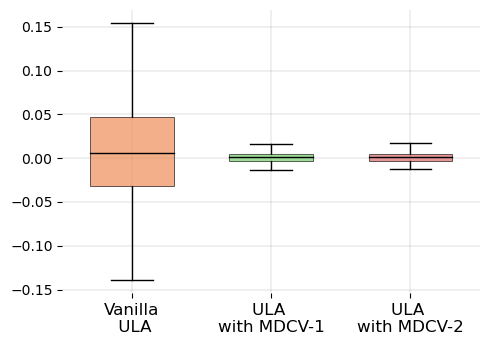

In [52]:
data = [res_list[0,:,0],res_list[-3,:,1], res_list[-3,:,2]] 
boxplot_ind(data, title, labels,path="./2d_gaussian_mixture_linear_29_10.pdf")

In [53]:
var_arr = np.var(res_list,axis=1)
print(var_arr.shape)

(10, 3)


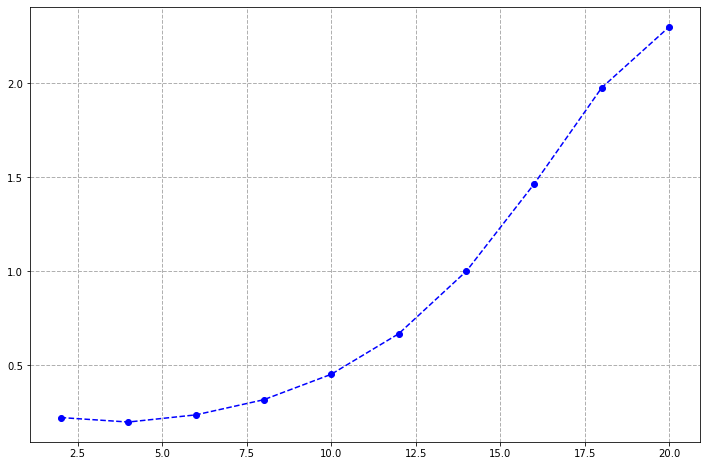

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
# plot the index for the x-values
#plt.plot(lags,vr_rates_dep/(lags*8), marker='o', linestyle='--', color='r', label='Train on dependent trajectories') 
plt.plot(lags,(var_arr[:,0]/(var_arr[:,2]*lags*4)), marker='o', linestyle='--', color='b') #,label='Train on independent trajectories') 
#plt.xlabel('lag',fontsize = 18)
#plt.ylabel('cost',fontsize = 18) 
#plt.title('VR cost for MDCV, Gaussian distribution, quadratic target',fontsize = 20)
plt.grid(linestyle='--', linewidth=1.0)
#plt.legend() 
#plt.show()
plt.savefig("./cost_2d_gaussian_mixture_linear_29_10.pdf")

In [ ]:
plt.figure(figsize=(12,8))
# plot the index for the x-values
#plt.plot(lags[:8],vr_rates_dep, marker='o', linestyle='--', color='r', label='Train on dependent trajectories') 
plt.plot(lags[:8],vr_rates_indep, marker='o', linestyle='--', color='b', label='Train on independent trajectories') 
#plt.xlabel('lag',fontsize = 18)
#plt.ylabel('VR rate',fontsize = 18) 
#plt.title('VR rates for MDCV, Gaussian Mixture, quadratic target',fontsize = 20)
plt.grid(linestyle='--', linewidth=1.0)
plt.legend() 
plt.show()